<a id='top'></a>

#Forest Cover Type Prediction



Date: August 18, 2024

LINK https://www.kaggle.com/c/forest-cover-type-prediction

##Contents

* <a href='#Objective'>Objective: Use cartographic variables to classify forest categories</a>

* <a href='#Data'>Loading, preparing, and exploring the data</a>

* <a href='#k-Nearest_Neighbors'>k-Nearest Neighbors (kNN)</a>

* <a href='#NB'>Naive Bayes (NB)</a>

* <a href='#Decision_Trees'>Decision Trees</a>

* <a href='#Random_Forests'>Random Forests</a>

* <a href='#ExtraTrees'>Extra Trees Classifier</a>

* <a href='#AdaBoost'>AdaBoost</a>

* <a href='#GB'>Gradient Boosting Classifier</a>

* <a href='#SVM'>Support Vector Machines</a>

* <a href='#Log_Regression'>Logistic Regression</a>

* <a href='#SGD'>Stochastic Gradient Descent (SGD)</a>

* <a href='#GMM'>Gaussian Mixture Model</a>

* <a href='#Ensemble'>Ensemble</a>

* <a href='#Results'>Results</a>

* <a href='#Annex_1'>Annex 1: Plotting the training dataset</a>

* <a href='#Annex_2'>Annex 2: Feature analysis</a>


We´ve used the most typical classifiers that we covered in the course, with the exception of **Neural Networks** (week 7). These are:

- **k Nearest Neighbors** (week 2)
- **Naive Bayes** (week 3)
- **Decision Trees**, as well as **Random Forests**, **AdaBoost**, and **Gradient Boosting** (week 4)
- **Logistic Regression** (week 5)
- **Stochastic Gradient Descen** (week 6)
- **Support Vector Machines** (week 8)
- **Gaussian Mixture Models** (week 10) used for classification

<a id='Objective'></a>

##Objective: Use cartographic variables to classify forest categories

<a href='#top'>[Back to top]</a>

In this competition we are asked to predict the **forest cover type** (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes 4 wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

Information about the **7 possible types** of forest cover (coded as integers from `1` to `7`), as well as the 54 features, can be found at https://www.kaggle.com/c/forest-cover-type-prediction/data.

As mentioned there, the training set contains 15,120 observations, whereas the test set contains 565,892 observations (about 37 times larger than the training set). Both sets contain information about 10 continuous features (listed below), and 2 categorical features (`wilderness area` and `soil type`), with 4 and 40 categories each (coded as 4 and 40 binary features, respectively, where 1 indicates presence and 0 indicates absence).

- Elevation (in meters)
- Aspect (in degrees azimuth)
- Slope (in degrees)
- Horizontal_Distance_To_Hydrology (i.e., to nearest surface water features)
- Vertical_Distance_To_Hydrology (ditto)
- Horizontal_Distance_To_Roadways (to nearest roadway)
- Hillshade_9am (0 to 255 index): Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index): Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index): Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points (i.e., to nearest wildfire ignition points)


<a id='Data'></a>

##Loading, preparing, and exploring the data

<a href='#top'>[Back to top]</a>

First we import the libraries we'll use along this project.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.grid_search import RandomizedSearchCV
from sklearn.mixture import GMM
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature preprocessing.
from sklearn import preprocessing

# SK-learn libraries for dimensionality reduction.
from sklearn.decomposition import PCA

# Data analysis and plotting 
import pandas as pd
import seaborn as sns
from scipy import stats

Next we load the training and test data sets.

In [2]:
ff = "train.csv"
f = open(ff)
column_names = f.readline()

data = np.loadtxt(f, delimiter=",")

y, X = data[:, -1].astype('u1'), data[:, :-1]

ff_test = "test.csv" # you will need to edit this directory
f_test = open(ff_test)
column_names_test = f_test.readline() # you'd needs this ordinarily

data_test = np.loadtxt(f_test, delimiter=",")

# note there are no labels here!
X_test = data_test

print 'The test dataset contains {0} observations with {1} features each.'.\
    format(X_test.shape[0], X_test.shape[1])
print '\t(The 1st one is not really a feature but an observation ID.)'
print 'The training dataset contains {0} observations with the same {1} features each.'.\
    format(X.shape[0], X.shape[1])
print 'For this training set we know the corresponding category (forest cover type) of the ' \
      '{0} observations.'.format(y.shape[0])

The test dataset contains 565892 observations with 55 features each.
	(The 1st one is not really a feature but an observation ID.)
The training dataset contains 15120 observations with the same 55 features each.
For this training set we know the corresponding category (forest cover type) of the 15120 observations.


Let's take a look at the distribution of values, for the continuous features.

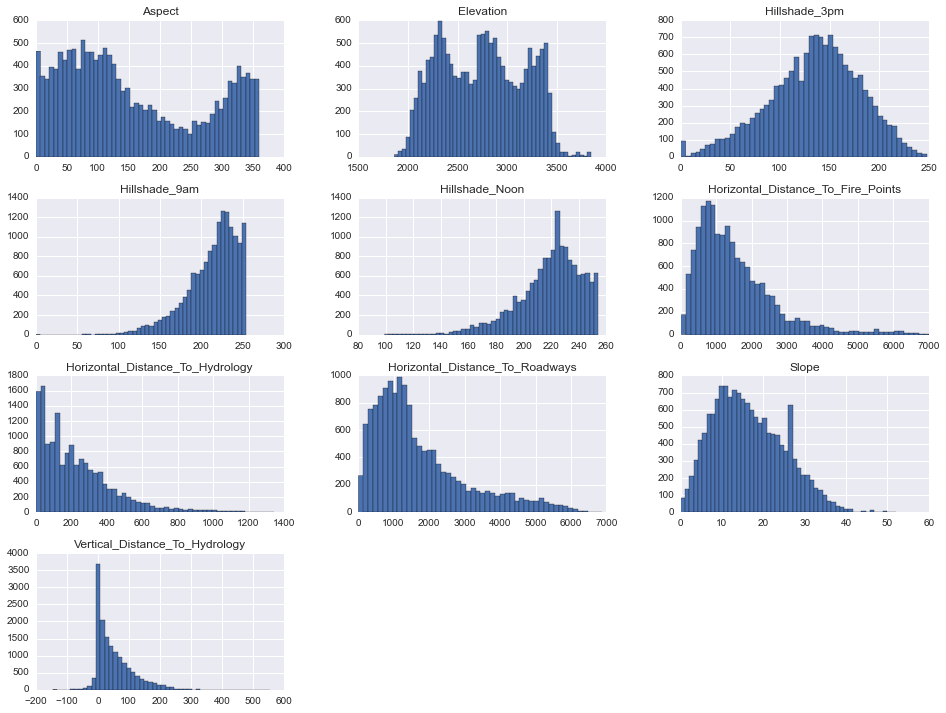

In [3]:
Train_panda = pd.read_csv('train.csv')
Train_panda.ix[:,1:11].hist(figsize=(16,12),bins=50)
plt.show()

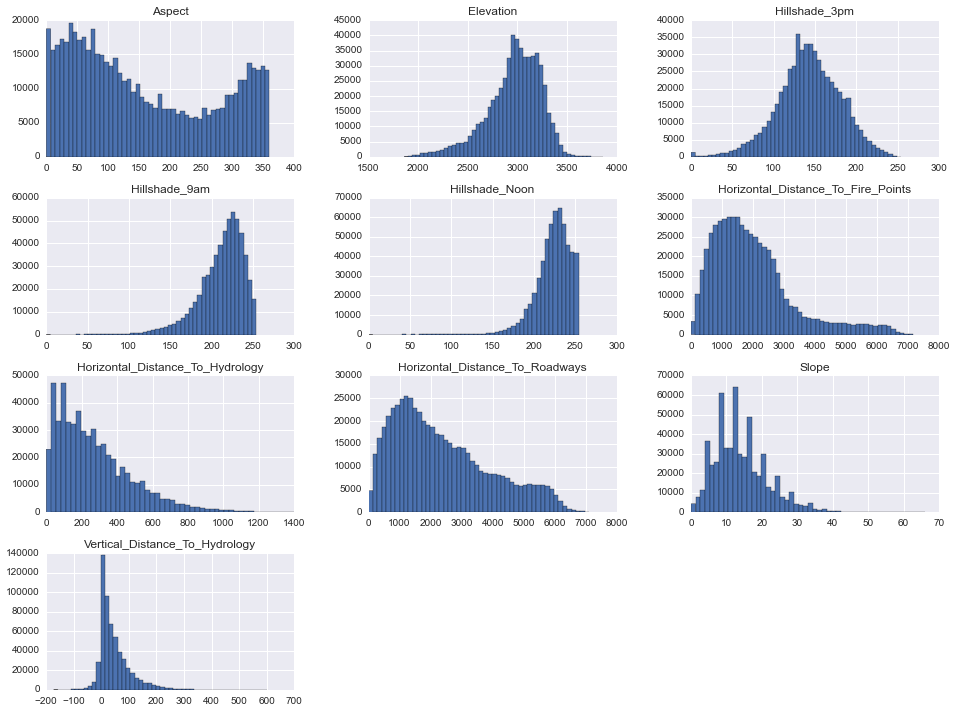

In [4]:
Test_panda = pd.read_csv('test.csv')
Test_panda.ix[:,1:11].hist(figsize=(16,12),bins=50)
plt.show()

The histograms of each feature, for both the training and test sets look quite similar (with the exception of `Elevation` and `Slope`). We noticed that the histogram of `Hillshade_3pm` contains several `0`'s, especially in the training set, which might make us think of missing values coded with `0`, but according to the dataset description that feature can take this value, so we shall accept those values as valid. There may be due to measurement error or rounding (in the same way that the histogram of `Hillshade_9am` for the training set contains more `255`'s than the distribution suggests), but in the absence of more information we can't substitute those `0`'s by some other value like hte median or the mean.

> We did that, anyway (substitute `0`'s by the median, as seen below), and the accuracy for the dev set increased slightly (by about 0.5%) in most of the models that we tried.

In [ ]:
# X[:,9] = np.where(X[:,9]==0, np.median(X[X[:,9]!=0,9]), X[:,9])
# X_test[:,9] = np.where(X_test[:,9]==0, np.median(X_test[X_test[:,9]!=0,9]), X_test[:,9])

To evaluate our performance, we'll split the training set in 2 subsets: **training** data (90%) plus **development** (aka **validation**) data (10%). **Test** data *must not* be used to validate our models, otherwise we might introduce bias: the more times we look at the error rate on the test set, the more we know about the test data, and the more we include our knowledge (that's very specific to that test data set) in the way we solve the problem.

> Nonetheless, in most cases we used *cross-validation* in many cases, to assess how the results of one model generalize to another data set: with this model validation technique, the training data are partitioned into complementary subsets, multiple rounds of cross-validation are performed using different partitions, and the results are averaged.

We also discard the 1st variable (ID), which does not provide any information about the forest cover type.

In [5]:
# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, y = X[shuffle], y[shuffle]

# Split into train (90%) and dev (10%)
train_size = int(X.shape[0] * 0.9)
# Also discard 1st feature (ID number that doesn't provide info about the label)
y_train, X_train = y[:train_size], X[:train_size, 1:]
y_dev, X_dev = y[train_size:], X[train_size:, 1:]
X_test = X_test[:, 1:]
print X_dev.shape, X_train.shape

(1512L, 54L) (13608L, 54L)


As previously mentioned, the first 10 features of each observation (`Elevation` to `Horizontal_Distance_To_Fire_Points`) are continuous, with different ranges, while the remaining 44 are all binary. 4 of those 44 binary features correspond to `Wilderness Area` (i.e., there are 4 possible types), so any observation will have one 1 and three 0's in those columns. The last 40 features correspond to `Soil Type` (i.e., there are 40 possible types), so any observation will have one 1 and thirty-nine 0's in those columns.

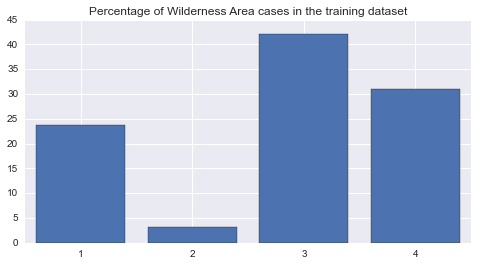

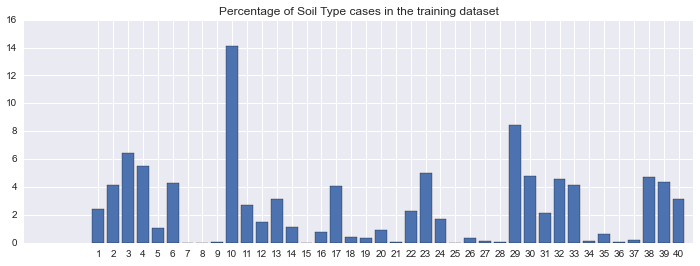

In [6]:
prop_wilderness = 100*X_train[:,10:14].sum(axis=0)/X_train[:,10:14].sum()
prop_soil = 100*X_train[:,14:54].sum(axis=0)/X_train[:,14:54].sum()

plt.figure(figsize=(8, 4))
plt.bar(np.arange(4), prop_wilderness, align="center")
plt.title("Percentage of Wilderness Area cases in the training dataset")
plt.xticks(np.arange(4), np.array([str(i) for i in np.arange(1,5)]))

plt.figure(figsize=(12, 4))
plt.bar(np.arange(40), prop_soil, align="center")
plt.title("Percentage of Soil Type cases in the training dataset")
plt.xticks(np.arange(40), np.array([str(i) for i in np.arange(1,41)]))

plt.show()

The type of `Wilderness Area` is roughly uniformly distributed among the observations in the training set, with the exception of the 2nd type (only 3.3%).

`Soil Type` is not uniformly distributed at all: many types are quite uncommon, while others account for up to 14.1% of the cases.

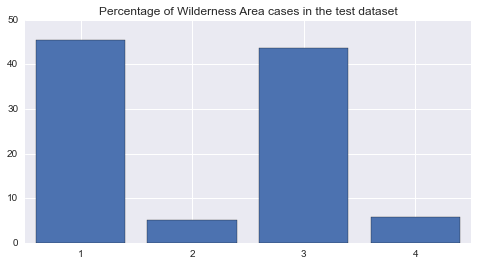

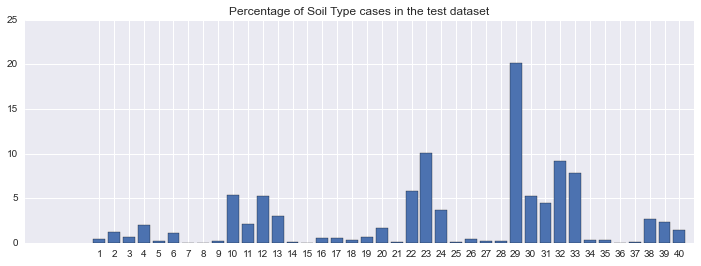

In [7]:
prop_wilderness = 100*X_test[:,10:14].sum(axis=0)/X_test[:,10:14].sum()
prop_soil = 100*X_test[:,14:54].sum(axis=0)/X_test[:,14:54].sum()

plt.figure(figsize=(8, 4))
plt.bar(np.arange(4), prop_wilderness, align="center")
plt.title("Percentage of Wilderness Area cases in the test dataset")
plt.xticks(np.arange(4), np.array([str(i) for i in np.arange(1,5)]))

plt.figure(figsize=(12, 4))
plt.bar(np.arange(40), prop_soil, align="center")
plt.title("Percentage of Soil Type cases in the test dataset")
plt.xticks(np.arange(40), np.array([str(i) for i in np.arange(1,41)]))

plt.show()

The distribution of the binary features differ quite much from the training to the test set.

For the 10 continuous features we sometimes used `preprocessing.StandardScaler` (to standardize themby removing the mean and scaling to unit variance), as well as `preprocessing.MinMaxScaler` (to standardize them by scaling each feature to a given range; [0,1] in our case, to make it comparable to the binary features). That did not always improve the results, but scaled features are mandatory for some models.

http://scikit-learn.org/stable/modules/preprocessing.html

In [8]:
# Scale to range [0,1]
    # Only the continuous features
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = np.copy(X_train)
X_dev_minmax = np.copy(X_dev)
X_test_minmax = np.copy(X_test)
X_train_minmax[:, :10] = min_max_scaler.fit_transform(X_train[:, :10])
X_dev_minmax[:, :10]  = min_max_scaler.transform(X_dev[:, :10])
X_test_minmax[:, :10] = min_max_scaler.transform(X_test[:, :10])

# Scale to mean = 0, sd = 1
std_scaler = preprocessing.StandardScaler()
# X_train_std = std_scaler.fit_transform(X_train)
# X_dev_std = std_scaler.transform(X_dev)
# X_test_std = std_scaler.transform(X_test)
    # Only the continuous features
X_train_std = np.copy(X_train)
X_dev_std = np.copy(X_dev)
X_test_std = np.copy(X_test)
X_train_std[:, :10] = std_scaler.fit_transform(X_train[:, :10])
X_dev_std[:, :10] = std_scaler.transform(X_dev[:, :10])
X_test_std[:, :10] = std_scaler.transform(X_test[:, :10])

<a id='k-Nearest_Neighbors'></a>

##k-Nearest Neighbors (kNN)

<a href='#top'>[Back to top]</a>


Because of the different nature of the 54 features (some continuous, some binary and mutually exclusive), we started creating our own distance metric that accounts for these differences to give similar weight to all the features. This new metric combined Euclidean and a variant of Hamming distance, and used the re-scaled version of the continuous variables, as explained in the code below. 

But the results were slightly worse than using the standard Euclidean distance, and after several tests, we discovered that the 44 binary features do not add too much information about the Cover Type. Using that standard Euclidean distance with unscaled data, with all features or just the 10 continuous ones, yields the best results.

The code below just shows some of the results we found.

In [10]:
# Create a mixed distance metric that accounts for the different characteristic of the features
    # to give a similar weight to all of them
# First 10 features are continuous. The square of differences is applied to the values scaled 
    # to [0,1] (maximum value of the sum = 10)
# Last 44 features correspond to 2 features (wilderness area and soil type), with 4 and 40
    # categories each. A variant of Hamming distance is applied to them, so the maximum value
    # is 2 if two observations differ in both features
# The total distance is the square of the sum of those 12 values, divided by the square of 12,
    # so the maximum distance between any two observations will be 1
# The ranges of the first 10 features may vary in the dev and test datasets, so the distances
    # might be slightly greater than 1
def mixed_distance(x, y):
    return np.sqrt(np.sum((x[:10]-y[:10])**2) + 0.5*np.sum(x[10:14]!=y[10:14]) +
                          0.5*np.sum(x[14:54]!=y[14:54])) / np.sqrt(12)

k = 1 # We also tried many other values of k
# Try our own metric
kNN_mixed = KNeighborsClassifier(n_neighbors=k, metric=mixed_distance)
kNN_mixed.fit(X_train_minmax, y_train)
print kNN_mixed.score(X_dev_minmax, y_dev)
# Try euclidean distance with unscaled data
kNN = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
kNN.fit(X_train, y_train)
print kNN.score(X_dev, y_dev)
# Try euclidean distance with scaled data
kNN = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
kNN.fit(X_train, y_train)
print kNN.score(X_dev, y_dev)
# Try euclidean distance with unscaled data and only continuous features
kNN.fit(X_train[:,:10], y_train)
print kNN.score(X_dev[:,:10], y_dev)
print

0.837962962963
0.853835978836
0.853835978836
0.853835978836



The optimal value for k is 1


(0, 11)

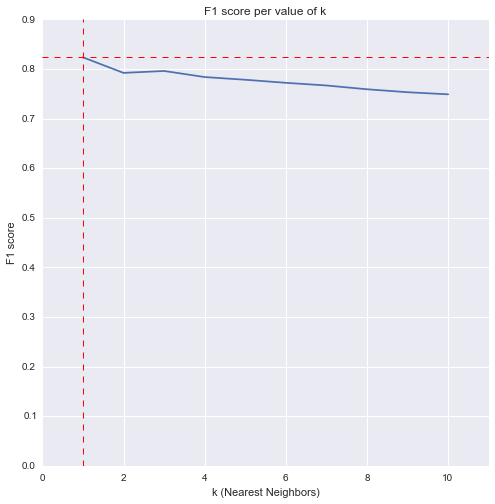

In [14]:
# Estimate by cross-validation the optimal number of neighbors (k)
# Try between 1 and the number of features (54)
k = {'n_neighbors': np.concatenate([np.arange(1, X_train.shape[1]+1)]).tolist()}
# The optimal value is low, so let's narrow the search from 1 to 11
k = {'n_neighbors': np.concatenate([np.arange(1, 10+1)]).tolist()}
best_param_kNN = GridSearchCV(KNeighborsClassifier(), k, scoring='accuracy')
best_param_kNN.fit(X_train, y_train)
optimal_k = best_param_kNN.best_params_['n_neighbors']
print 'The optimal value for k is {0}'.format(optimal_k)

# Plot results
f1_vector = np.array([best_param_kNN.grid_scores_[x][1] for x in 
                      range(len(k['n_neighbors']))])
plt.figure(figsize=(8, 8))
plt.plot(k['n_neighbors'], f1_vector, marker='x')
plt.axvline(x=optimal_k, linewidth=1, linestyle='--', color='red')
plt.axhline(y=best_param_kNN.best_score_, linewidth=1, linestyle='--', color='red')
plt.xlabel("k (Nearest Neighbors)")
plt.ylabel("F1 score")
plt.title('F1 score per value of k')
plt.ylim([0, (np.ceil(best_param_kNN.best_score_*20)+1)/20])
plt.xlim([0, len(k['n_neighbors'])+1])

How well does our first model perform on the development data?

In [15]:
kNN = KNeighborsClassifier(n_neighbors=optimal_k)

kNN.fit(X_train, y_train)
print 'Accuracy using non-scaled data:      {0:.4f}'.\
    format(kNN.score(X_dev, y_dev))

kNN.fit(X_train_std, y_train)
print 'Accuracy using standardized data:    {0:.4f}'.\
    format(kNN.score(X_dev_std, y_dev))

kNN.fit(X_train_minmax, y_train)
print 'Accuracy using scaled-to-range data: {0:.4f}'.\
    format(kNN.score(X_dev_minmax, y_dev))

Accuracy using non-scaled data:      0.8538
Accuracy using standardized data:    0.8201
Accuracy using scaled-to-range data: 0.8380


The model performs better with non-scaled data (it could be argued that we searched for the optimal value for k using those data, but we did the same -out of this notebook- with standardized and scaled-to-range data).

Which are the cover types most commonly misclassified?

In [16]:
kNN = KNeighborsClassifier(n_neighbors=optimal_k)
kNN.fit(X_train[:, :10], y_train)
predicted_y_dev = kNN.predict(X_dev[:, :10])
print classification_report(y_dev, predicted_y_dev)
# Confusion Matrix
CM = metrics.confusion_matrix(y_dev, predicted_y_dev)
CM_percentage = np.around(100*CM.astype('f2') / CM.sum(axis=1)[:, np.newaxis], 1)

# plt.figure(figsize=(12, 12))
# ax = plt.gca()
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
# ax.axis('off')
# table2 = plt.table(cellText=CM_percentage,rowLabels=np.arange(1,8),
#                            colLabels=np.arange(1,8),loc='center')
# plt.show()

# Print a table with the confusion matrix (percentages of row, so each row correspond to the
    # true cover type, and the diagonal values correspond to the Recall / 100
cover_type = [c.rjust(5) for c in map(str, np.unique(y_dev))]
print "|    |{}|{}|{}|{}|{}|{}|{}|".format(*cover_type)
print '------------------------------------------------'
table = []
for i,j in enumerate(np.unique(y_dev)):
    table.append([j, CM_percentage[i,0], CM_percentage[i,1], CM_percentage[i,2],
                  CM_percentage[i,3], CM_percentage[i,4], CM_percentage[i,5],
                  CM_percentage[i,6]])
for i in table:
    print "|{:4}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|".format(*i)
print

             precision    recall  f1-score   support

          1       0.80      0.67      0.73       220
          2       0.72      0.66      0.69       208
          3       0.85      0.81      0.83       220
          4       0.94      0.96      0.95       212
          5       0.89      0.96      0.93       227
          6       0.83      0.91      0.87       206
          7       0.90      0.99      0.95       219

avg / total       0.85      0.85      0.85      1512

|    |    1|    2|    3|    4|    5|    6|    7|
------------------------------------------------
|   1| 67.3| 18.6|  0.0|  0.0|  4.1|  0.5|  9.5|
|   2| 16.3| 66.3|  5.8|  0.0|  6.7|  3.8|  1.0|
|   3|  0.0|  1.8| 80.9|  5.5|  0.5| 11.4|  0.0|
|   4|  0.0|  0.0|  1.9| 96.2|  0.0|  1.9|  0.0|
|   5|  0.0|  3.1|  0.0|  0.0| 96.5|  0.4|  0.0|
|   6|  0.0|  0.5|  7.3|  0.5|  1.0| 90.8|  0.0|
|   7|  0.9|  0.0|  0.0|  0.0|  0.0|  0.0| 99.1|



The cover types most typically misclassified are 1 and 2 (confused with each other).

Keep record of the predictions in the dev set, as well as the accuracy, to ensemble all the models in a later step:

In [19]:
kNN = KNeighborsClassifier(n_neighbors=optimal_k)
kNN.fit(X_train, y_train)
pred_y_dev_kNN = kNN.predict(X_dev)
acc_kNN = metrics.accuracy_score(y_dev, pred_y_dev_kNN)
print acc_kNN

CM = metrics.confusion_matrix(y_dev, pred_y_dev_kNN)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_kNN_perType = np.diag(acc)
print acc_kNN_perType

0.853835978836
[ 0.67272727  0.66346154  0.80909091  0.96226415  0.96475771  0.90776699
  0.99086758]


Predict the test set:

In [68]:
pred_y_test_kNN = kNN.predict(X_test)

<a id='NB'></a>

##Naive Bayes (NB)

<a href='#top'>[Back to top]</a>


In [69]:
NB_model = GaussianNB()
NB_model.fit(X_train_std[:,:10], y_train)
dev_predicted_labels = NB_model.predict(X_dev_std[:,:10])
print metrics.accuracy_score(y_true=y_dev, y_pred=dev_predicted_labels)
print metrics.classification_report(y_dev, dev_predicted_labels)

0.590608465608
             precision    recall  f1-score   support

          1       0.55      0.56      0.55       220
          2       0.50      0.42      0.46       208
          3       0.50      0.40      0.44       220
          4       0.71      0.78      0.74       212
          5       0.62      0.69      0.65       227
          6       0.45      0.47      0.46       206
          7       0.75      0.80      0.78       219

avg / total       0.58      0.59      0.58      1512



Keep record of the predictions in the dev set, as well as the accuracy, to ensemble all the models in a later step:

In [70]:
NB = GaussianNB()
NB.fit(X_train_std[:,:10], y_train)
pred_y_dev_NB = NB.predict(X_dev_std[:,:10])
acc_NB = metrics.accuracy_score(y_dev, pred_y_dev_NB)
print acc_NB

CM = metrics.confusion_matrix(y_dev, pred_y_dev_NB)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_NB_perType = np.diag(acc)
print acc_NB_perType

0.590608465608
[ 0.56363636  0.41826923  0.39545455  0.78301887  0.69162996  0.47087379
  0.79908676]


Predict the test set:

In [73]:
pred_y_test_NB = NB.predict(X_test_std[:,:10])

<a id='Decision_Trees'></a>

##Decision Trees

<a href='#top'>[Back to top]</a>

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression.

Motivation for using the decision trees for our dataset
* The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
* Able to handle both numerical and categorical data.

Specially being able to handle both numeric and catergorical data something that suits our purpose since we have both of them in our data.


In [172]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_features': [2, 5, 10, 20, 54], 
              'max_depth': [5, 10, 20, 25, 30, 40]}
best_param_DT = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='accuracy')
best_param_DT.fit(X_train, y_train)
optimal_criterion_DT = best_param_DT.best_params_['criterion']
print 'The optimal criterion is {0}'.format(optimal_criterion_DT)
optimal_max_features_DT = best_param_DT.best_params_['max_features']
print 'The optimal maximum number of features is {0}'.format(optimal_max_features_DT)
optimal_max_depth_DT = best_param_DT.best_params_['max_depth']
print 'The optimal maximum depth of the tree is {0}'.format(optimal_max_depth_DT)

DT = DecisionTreeClassifier(criterion=optimal_criterion_DT, max_features=optimal_max_features_DT, 
                            max_depth=optimal_max_depth_DT, random_state=0)
DT.fit(X_train, y_train)

y_dev_dec = DT.predict(X_dev)
print metrics.classification_report(y_dev, y_dev_dec)
print metrics.accuracy_score(y_dev, y_dev_dec)

The optimal criterion is entropy
The optimal maximum number of features is 54
The optimal maximum depth of the tree is 30
             precision    recall  f1-score   support

          1       0.71      0.68      0.69       220
          2       0.66      0.62      0.64       208
          3       0.81      0.76      0.78       220
          4       0.96      0.94      0.95       212
          5       0.86      0.90      0.88       227
          6       0.78      0.85      0.81       206
          7       0.92      0.96      0.94       219

avg / total       0.82      0.82      0.82      1512

0.818121693122


Keep record of the predictions in the dev set, as well as the accuracy, to ensemble all the models in a later step:

In [173]:
DT = DecisionTreeClassifier(criterion='entropy', max_features=54, 
                            max_depth=25, random_state=0)
DT.fit(X_train, y_train)
pred_y_dev_DT = DT.predict(X_dev)
acc_DT = metrics.accuracy_score(y_dev, pred_y_dev_DT)
print acc_DT

CM = metrics.confusion_matrix(y_dev, pred_y_dev_DT)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_DT_perType = np.diag(acc)
print acc_DT_perType

0.818121693122
[ 0.67727273  0.62019231  0.75909091  0.94339623  0.9030837   0.85436893
  0.96347032]


Predict the test set:

In [174]:
pred_y_test_DT = DT.predict(X_test)

<a id='Random_Forests'></a>

##Random Forests
<a href='#top'>[Back to top]</a>

Given how closely decision trees can fit themselves to their training data, they have a tendency to overfit. One way of avoiding this is a technique called random forests, in which we build multiple decision trees and let them vote on how to classify inputs:

**Random forests** are ensembles of decision trees. *Multiple decision trees* are trained and aggregated to form a model that is more performant than any of the individual trees. This general idea is the purpose of ensemble learning.

In [175]:
# Train and predict with the random forest classifier
param_grid = {'criterion': ['gini', 'entropy'], 'n_estimators': [10, 50, 150], 
              'min_samples_split': [2, 4], 'max_features': [2, 5, 10, 20, 54], 
              'max_depth': [10, 20, 25, 30, 40]}
best_param_RF = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, scoring='accuracy')
best_param_RF.fit(X_train, y_train)
optimal_criterion_RF = best_param_RF.best_params_['criterion']
print 'The optimal criterion is {0}'.format(optimal_criterion_RF)
optimal_n_estimators_RF = best_param_RF.best_params_['n_estimators']
print 'The optimal number of trees in the forest is {0}'.format(optimal_n_estimators_RF)
optimal_min_samples_split_RF = best_param_RF.best_params_['min_samples_split']
print 'The optimal minimum number of samples required to split an internal node is {0}'.\
    format(optimal_min_samples_split_RF)
optimal_max_features_RF = best_param_RF.best_params_['max_features']
print 'The optimal maximum number of features is {0}'.format(optimal_max_features_RF)
optimal_max_depth_RF = best_param_DT.best_params_['max_depth']
print 'The optimal maximum depth of the tree is {0}'.format(optimal_max_depth_RF)

RF = ensemble.RandomForestClassifier(criterion=optimal_criterion_RF, 
                                     n_estimators=optimal_n_estimators_RF, 
                                     min_samples_split=optimal_min_samples_split_RF, 
                                     max_features=optimal_max_features_RF, 
                                     max_depth=optimal_max_depth_RF, random_state=0)
RF.fit(X_train,y_train)
y_dev_RF = RF.predict(X_dev)
print metrics.classification_report(y_dev, y_dev_RF)
print metrics.accuracy_score(y_dev, y_dev_RF)

The optimal criterion is entropy
The optimal number of trees in the forest is 150
The optimal minimum number of samples required to split an internal node is 2
The optimal maximum number of features is 20
The optimal maximum depth of the tree is 30
             precision    recall  f1-score   support

          1       0.84      0.80      0.82       220
          2       0.85      0.74      0.79       208
          3       0.88      0.83      0.86       220
          4       0.98      0.98      0.98       212
          5       0.91      0.96      0.93       227
          6       0.83      0.94      0.88       206
          7       0.94      0.98      0.96       219

avg / total       0.89      0.89      0.89      1512

0.890873015873


Keep record of the predictions in the dev set, as well as the accuracy, to ensemble all the models in a later step:

In [176]:
RF = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=150, 
                                     min_samples_split=2, max_features=20, 
                                     max_depth=25, random_state=0)
RF.fit(X_train,y_train)
pred_y_dev_RF = RF.predict(X_dev)
acc_RF = metrics.accuracy_score(y_dev, pred_y_dev_RF)
print acc_RF

CM = metrics.confusion_matrix(y_dev, pred_y_dev_RF)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_RF_perType = np.diag(acc)
print acc_RF_perType

0.887566137566
[ 0.80454545  0.72596154  0.83181818  0.98113208  0.95594714  0.9368932
  0.97260274]


Predict the test set:

In [177]:
pred_y_test_RF = RF.predict(X_test)

###Engineering New Features

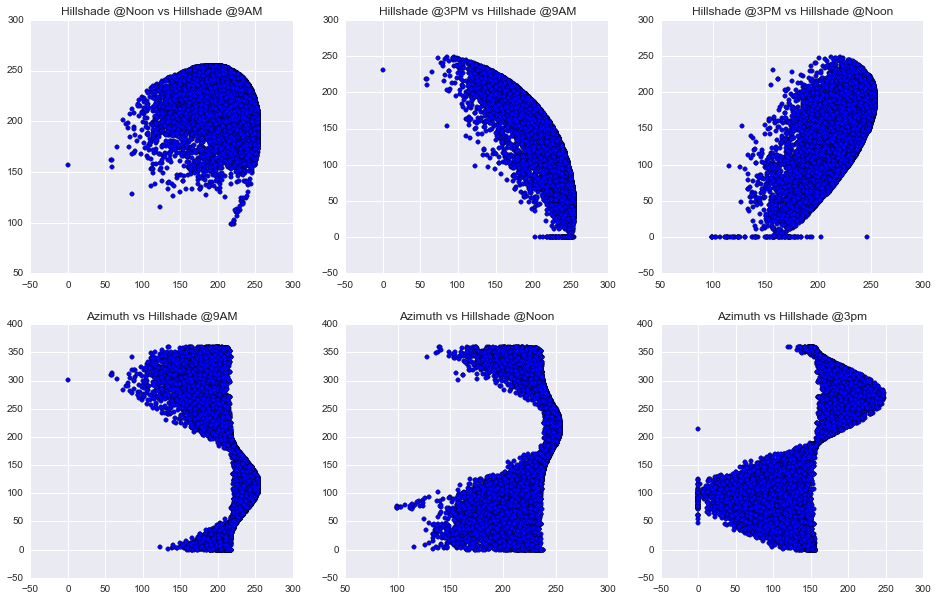

In [178]:
#Computes the coordinate distance to hydrology based on horizontal and vertical distance to hydrology

distance_to_hydrology = metrics.euclidean_distances(X_train[:,(3,4)], np.array([0,0]))

X_train_new = np.append(X_train,distance_to_hydrology,axis=1)

#thresholding hillshade features
X_train_new[:,6]= np.floor_divide(X_train[:,6],64)
X_train_new[:,7]= np.floor_divide(X_train[:,7],64)
X_train_new[:,8]= np.floor_divide(X_train[:,8],64)

X_train_new_del = np.delete(X_train_new,[3,4],axis=1)

distance_to_hydrology = metrics.euclidean_distances(X_dev[:,(3,4)], np.array([0,0]))

X_dev_new = np.append(X_dev,distance_to_hydrology,axis=1)

#thresholding hillshade features
X_dev_new[:,6]= np.floor_divide(X_dev[:,6],64)
X_dev_new[:,7]= np.floor_divide(X_dev[:,7],64)
X_dev_new[:,8]= np.floor_divide(X_dev[:,8],64)

X_dev_new_del = np.delete(X_dev_new,[3,4],axis=1)

plt.figure(figsize=(16,10))
#Scatter Plot of hillshade index
plt.subplot(2,3,1)
plt.scatter(X_train[:,6],X_train[:,7])
plt.title("Hillshade @Noon vs Hillshade @9AM")

plt.subplot(2,3,2)
plt.scatter(X_train[:,6],X_train[:,8])
plt.title("Hillshade @3PM vs Hillshade @9AM")

plt.subplot(2,3,3)
plt.scatter(X_train[:,7],X_train[:,8])
plt.title("Hillshade @3PM vs Hillshade @Noon")

plt.subplot(2,3,4)
plt.scatter(X_train[:,6],X_train[:,1])
plt.title("Azimuth vs Hillshade @9AM")

plt.subplot(2,3,5)
plt.scatter(X_train[:,7],X_train[:,1])
plt.title("Azimuth vs Hillshade @Noon ")

plt.subplot(2,3,6)
plt.scatter(X_train[:,8],X_train[:,1])
plt.title("Azimuth vs Hillshade @3pm")

plt.show()

###Random Forest with engineered feature

In [179]:
# update X_train_new with 10 squared columns of continous variables
# Train and predict with the random forest classifier
firstTen=[0,1,2,3,4,5,6,7,8,9]
X_10sq = np.square((X_train[:,firstTen]))
X_sum=np.sum(X_10sq,axis=1)

X_train_tmp=np.delete(X_train,firstTen,axis=1)
X_train_10sq=np.hstack((X_10sq,X_train_tmp))
X_sum=np.reshape(X_sum,(X_sum.shape[0],1))
X_train_10sq=np.hstack((X_train_10sq,X_sum))


firstTen=range(10)
X_10sq = np.square((X_dev[:,firstTen]))
X_sum=np.sum(X_10sq,axis=1)
X_dev_tmp=np.delete(X_dev,firstTen,axis=1)
X_dev_10sq=np.hstack((X_10sq,X_dev_tmp))
X_sum=np.reshape(X_sum,(X_sum.shape[0],1))
X_dev_10sq=np.hstack((X_dev_10sq,X_sum))

X_10sq = np.square((X_train[:,firstTen]))
X_sum=np.sum(X_10sq,axis=1)
X_train_tmp=np.delete(X_train,firstTen,axis=1)
X_train_10sq=np.hstack((X_10sq,X_train_tmp))
X_sum=np.reshape(X_sum,(X_sum.shape[0],1))
X_train_10sq=np.hstack((X_train_10sq,X_sum))

elev_hydro_vert=[0,3]
print X_dev.shape
X_elev_hydro_vert = np.square((X_dev[:,elev_hydro_vert]))
print X_elev_hydro_vert.shape
#process X_dev
X_sum=np.sum(X_elev_hydro_vert,axis=1)
print X_sum.shape
X_sum=np.reshape(X_sum,(X_sum.shape[0],1))
print X_sum.shape
tmp=np.delete(X_dev,elev_hydro_vert,axis=1)
print tmp.shape
X_dev_f1=np.hstack((X_sum,tmp))
print X_dev_f1.shape

(1512L, 54L)
(1512L, 2L)
(1512L,)
(1512L, 1L)
(1512L, 52L)
(1512L, 53L)


In [180]:
elev_hydro_vert=[0,3]
X_elev_hydro_vert = np.square((X_train[:,elev_hydro_vert]))
#process X_dev
X_sum=np.sum(X_elev_hydro_vert,axis=1)
X_sum=np.reshape(X_sum,(X_sum.shape[0],1))
tmp=np.delete(X_train,elev_hydro_vert,axis=1)
X_train_f1=np.hstack((X_sum,tmp))

In [181]:
%%time
rf = ensemble.RandomForestClassifier(criterion=optimal_criterion_RF, 
                                     n_estimators=optimal_n_estimators_RF, 
                                     min_samples_split=optimal_min_samples_split_RF, 
                                     max_features=optimal_max_features_RF, random_state=0)
rf.fit(X_train_10sq,y_train)
y_dev_rf = rf.predict(X_dev_10sq)
print metrics.classification_report(y_dev, y_dev_rf)
print metrics.accuracy_score(y_dev, y_dev_rf)

rf.fit(X_train_new,y_train)
y_dev_rf = rf.predict(X_dev_new)
print metrics.classification_report(y_dev, y_dev_rf)
print metrics.accuracy_score(y_dev, y_dev_rf)

             precision    recall  f1-score   support

          1       0.84      0.80      0.82       220
          2       0.84      0.73      0.78       208
          3       0.87      0.83      0.85       220
          4       0.98      0.98      0.98       212
          5       0.90      0.96      0.93       227
          6       0.85      0.96      0.90       206
          7       0.96      0.98      0.97       219

avg / total       0.89      0.89      0.89      1512

0.891534391534
             precision    recall  f1-score   support

          1       0.83      0.80      0.81       220
          2       0.83      0.73      0.78       208
          3       0.87      0.82      0.85       220
          4       0.97      0.97      0.97       212
          5       0.91      0.95      0.93       227
          6       0.84      0.95      0.89       206
          7       0.94      0.99      0.96       219

avg / total       0.89      0.89      0.88      1512

0.886243386243
Wall time:

<a id='ExtraTrees'></a>

##Extra Trees Classifier

<a href='#top'>[Back to top]</a>

Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the max_features randomly selected features and the best split among those is chosen.

In [182]:
param_grid = {'criterion': ['gini', 'entropy'], 
              'n_estimators': [10, 50, 150], 
              'min_samples_split': [2, 4], 
              'max_features': [2, 5, 10, 20, 54]}
best_param_ET = GridSearchCV(ensemble.ExtraTreesClassifier(), param_grid, scoring='accuracy')
best_param_ET.fit(X_train, y_train)
optimal_criterion_ET = best_param_ET.best_params_['criterion']
print 'The optimal criterion is {0}'.format(optimal_criterion_ET)
optimal_n_estimators_ET = best_param_ET.best_params_['n_estimators']
print 'The optimal number of trees in the forest is {0}'.format(optimal_n_estimators_ET)
optimal_min_samples_split_ET = best_param_RF.best_params_['min_samples_split']
print 'The optimal minimum number of samples required to split an internal node is {0}'.\
    format(optimal_min_samples_split_ET)
optimal_max_features_ET = best_param_ET.best_params_['max_features']
print 'The optimal maximum number of features is {0}'.format(optimal_max_features_ET)

ET = ensemble.ExtraTreesClassifier(criterion=optimal_criterion_ET, 
                                   n_estimators=optimal_n_estimators_ET, 
                                   min_samples_split=optimal_min_samples_split_ET, 
                                   max_features=optimal_max_features_ET, random_state=0)

ET.fit(X_train, y_train )       
y_dev_et = ET.predict(X_dev)
print metrics.accuracy_score(y_dev, y_dev_et)
print metrics.classification_report(y_dev, y_dev_et)

The optimal criterion is entropy
The optimal number of trees in the forest is 150
The optimal minimum number of samples required to split an internal node is 2
The optimal maximum number of features is 54
0.893518518519
             precision    recall  f1-score   support

          1       0.85      0.78      0.81       220
          2       0.82      0.76      0.79       208
          3       0.89      0.85      0.87       220
          4       0.97      0.98      0.97       212
          5       0.92      0.96      0.94       227
          6       0.85      0.94      0.89       206
          7       0.94      0.99      0.96       219

avg / total       0.89      0.89      0.89      1512



Keep record of the predictions in the dev set, as well as the accuracy, to ensemble all the models in a later step:

In [209]:
ET = ensemble.ExtraTreesClassifier(criterion='entropy', n_estimators=150, 
                                   min_samples_split=2, max_features=54, 
                                   random_state=0)
ET.fit(X_train,y_train)
pred_y_dev_ET = ET.predict(X_dev)
acc_ET = metrics.accuracy_score(y_dev, pred_y_dev_ET)
print acc_ET

CM = metrics.confusion_matrix(y_dev, pred_y_dev_ET)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_ET_perType = np.diag(acc)
print acc_ET_perType

0.893518518519
[ 0.77727273  0.75961538  0.85        0.98113208  0.96035242  0.9368932
  0.98630137]


Predict the test set:

In [210]:
pred_y_test_ET = ET.predict(X_test)

<a id='AdaBoost'></a>

##AdaBoost

<a href='#top'>[Back to top]</a>

"An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases." (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

First we establish a baseline result with Adaboost.

Some observations:

1. Elevation alongwith all the distance metrics appear to be the most important features.

2. Two problems are evident from looking at the confusion matrix:

    a) The model gets confused with Forest Cover 1 and Forest Cover 2.
    
    b) The model also incorrectly classifies Forest Cover 3 as Forest Cover 6 in quite a few instances.

Our feature engineering effort will attempt to reduce this misclassification rate.

Creating a general function to plot N important features

In [257]:
fet_ind=[]
name_features = column_names_test.split(",")

def plot_important_features(rf,nFeatures,features):
    global fet_ind
    plt.figure(figsize=(8, 4))
    fet_ind = np.argsort(rf.feature_importances_)[::-1]
    fet_imp = rf.feature_importances_[fet_ind][:nFeatures]
    feature_names =features[1:]
    feature_names_array=np.array(feature_names)[fet_ind]
    feature_names=feature_names_array[:nFeatures].tolist()
    
    #print "%d most important features are\n" % nFeatures
    #print fet_ind[:nFeatures]
    #print feature_names
    
    #plot the bar chart for most important features 
    plt.bar(np.arange(len(fet_imp)), fet_imp, width=1, lw=2)
    plt.grid(False)
    xt = np.arange(len(fet_imp)+0.5)
    ax = plt.subplot(111)
    ax.set_xticks(xt)
    xlabels=feature_names_array.tolist()
    ax.set_xticklabels(xlabels, rotation=90)
    plt.xlim(0, len(fet_imp))
    plt.show()

Creating a general function to print a confusion matrix:

In [258]:
def print_confusion_matrix(y_dev,y_pred):
    CM = metrics.confusion_matrix(y_dev, y_pred)
    CM_percentage = np.around(100*CM.astype('f2') / CM.sum(axis=1)[:, np.newaxis], 1)

    cover_type = [c.rjust(5) for c in map(str, np.unique(y_dev))]
    print "|    |{}|{}|{}|{}|{}|{}|{}|".format(*cover_type)
    print '------------------------------------------------'
    table = []
    for i,j in enumerate(np.unique(y_dev)):
        table.append([j, CM_percentage[i,0], CM_percentage[i,1], CM_percentage[i,2],
                      CM_percentage[i,3], CM_percentage[i,4], CM_percentage[i,5],
                      CM_percentage[i,6]])
    for i in table:
        print "|{:4}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|".format(*i)
    print

Accuracy (adaboost with decision trees NORMAL new feature): 0.894841269841


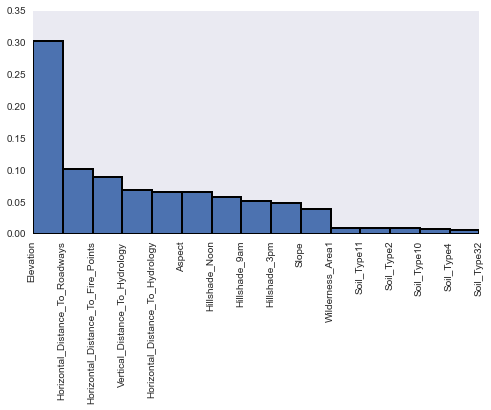


Confusion Matrix

|    |    1|    2|    3|    4|    5|    6|    7|
------------------------------------------------
|   1| 76.8| 13.2|  0.0|  0.0|  1.8|  0.0|  8.2|
|   2| 13.0| 75.5|  4.8|  0.0|  4.8|  1.4|  0.5|
|   3|  0.0|  0.0| 85.5|  2.3|  0.9| 11.4|  0.0|
|   4|  0.0|  0.0|  0.5| 98.6|  0.0|  0.9|  0.0|
|   5|  0.0|  1.8|  0.9|  0.0| 96.0|  1.3|  0.0|
|   6|  0.0|  0.0|  4.9|  0.0|  0.0| 95.1|  0.0|
|   7|  1.4|  0.0|  0.0|  0.0|  0.0|  0.0| 98.6|



In [259]:
name_features = column_names_test.split(",")
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=500, learning_rate=1.0)
abc.fit(X_train, y_train)
y_pred = abc.predict(X_dev)
print 'Accuracy (adaboost with decision trees NORMAL new feature):', abc.score(X_dev,y_dev)
#print classification_report(y_dev,y_pred)

plot_important_features(abc,15,name_features)

print "\nConfusion Matrix\n"
print_confusion_matrix(y_dev,y_pred)

Creating a generic function to create box-plot for the continuous features separated by the forest cover labels:

In [260]:
def box_plot(name_features,feature_num,X_train):
    
    feature_name = name_features[feature_num+1]
    plt.boxplot([X_train[:,feature_num][y_train==1],X_train[:,feature_num][y_train==2],
                 X_train[:,feature_num][y_train==3],X_train[:,feature_num][y_train==4],
                 X_train[:,feature_num][y_train==5],X_train[:,feature_num][y_train==6],
                 X_train[:,feature_num][y_train==7]])

    plt.title(feature_name)

Creating boxplots for each of the 10 continuous features separated by the forest cover labels.
Some Observations:

1. Elevation truly is the most important feature in our dataset because it adequately separates all of the forest cover labels.

2. Forest Cover 1 and Forest Cover 2 are very similar in terms of the other continuous features (except for Elevation), and is most likely the cause for the higher misclassification rate.

3. Forest Cover 3 and Forest Cover 6 are quite similar in terms of elevation (the most important feature) and probably explains why Forest Cover 3 gets incorrectly predicted as Forest Cover 6 at a relatively high rate.

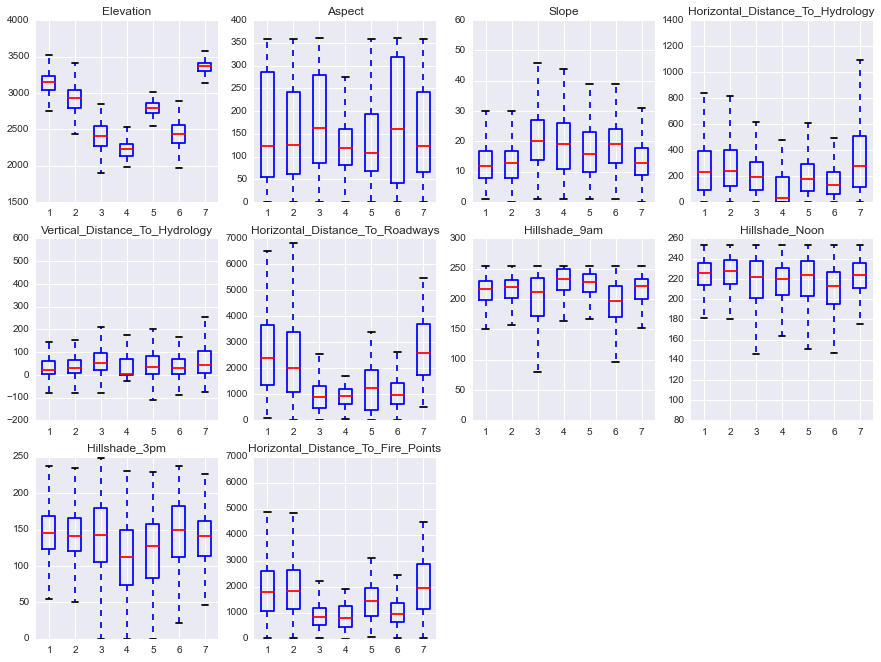

In [261]:
name_features = column_names_test.split(",")

plt.figure(figsize=(15,15))

for i in range(10):    
    plt.subplot(4,4,i+1)
    box_plot(name_features,i,X_train)

plt.show()

Creating a scatter matrix for the top 6 features computed using baseline Adaboost:

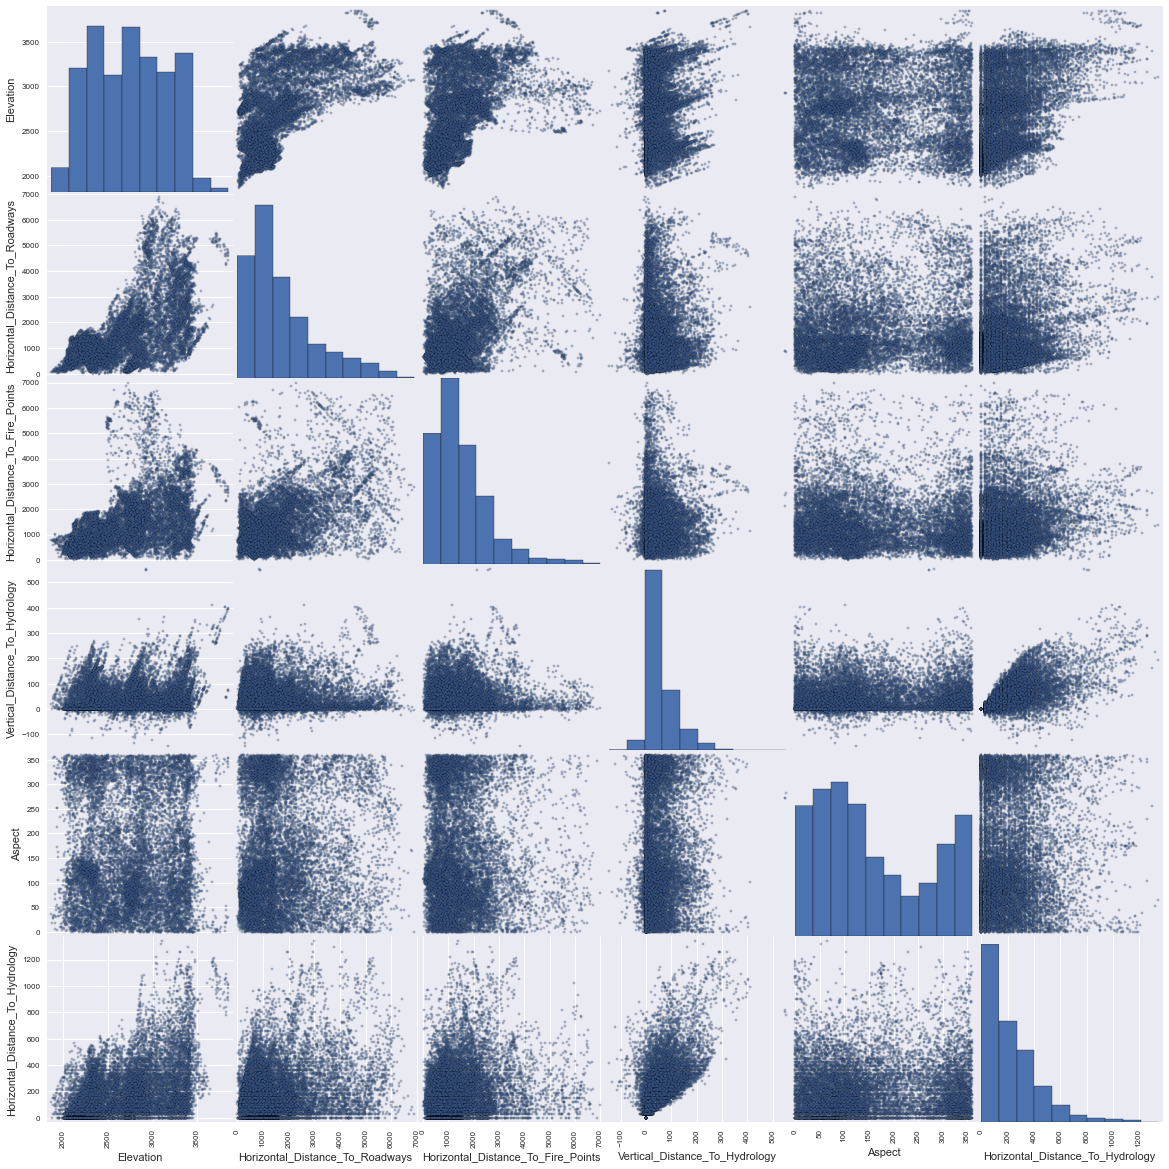

In [262]:
y_train_reshape = np.reshape(y_train,(y_train.shape[0],1))

df_pre = np.concatenate((X_train,y_train_reshape),axis=1)
df = pd.DataFrame(df_pre[:,(0,5,9,4,1,3)],columns=["Elevation","Horizontal_Distance_To_Roadways",
                                        "Horizontal_Distance_To_Fire_Points",
                                        "Vertical_Distance_To_Hydrology",
                                        "Aspect",
                                        "Horizontal_Distance_To_Hydrology"])

pd.tools.plotting.scatter_matrix(df, alpha=0.4,figsize=(20,20))
plt.show()

Also, creating a scatter plot for the different combinations of the hillshade indexes.

Observations:

1. There appears to be a negative correlation between hillshade @3pm vs hillshade@9am

2. There appears to be a positive correlation between hillshade @3pm vs hillshade@noon

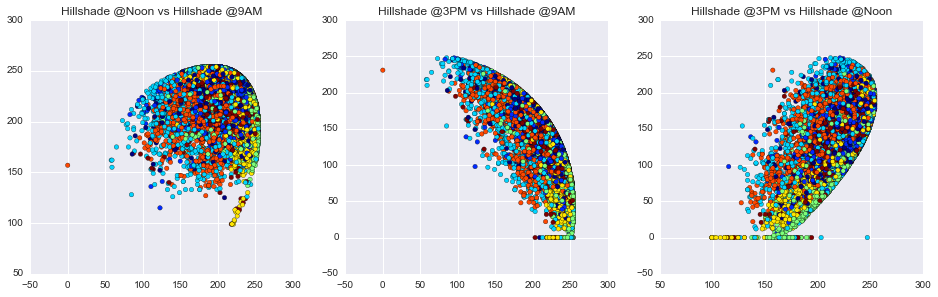

In [263]:
plt.figure(figsize=(16,10))
#Scatter Plot of hillshade index
plt.subplot(2,3,1)
plt.scatter(X_train[:,6],X_train[:,7],c=y_train,cmap=plt.cm.jet)
plt.title("Hillshade @Noon vs Hillshade @9AM")

plt.subplot(2,3,2)
plt.scatter(X_train[:,6],X_train[:,8],c=y_train,cmap=plt.cm.jet)
plt.title("Hillshade @3PM vs Hillshade @9AM")

plt.subplot(2,3,3)
plt.scatter(X_train[:,7],X_train[:,8],c=y_train,cmap=plt.cm.jet)
plt.title("Hillshade @3PM vs Hillshade @Noon")

plt.show()

In the scatter matrix, two relationships jumped out at us.

1. There appears to be a positive correlation between elevation and horizontal distance to hydrology
2. There appears to be a positive correlation between vertical and horizontal distance to hydrology
3. Vertical distance to hydrology and elevation also appear to be related

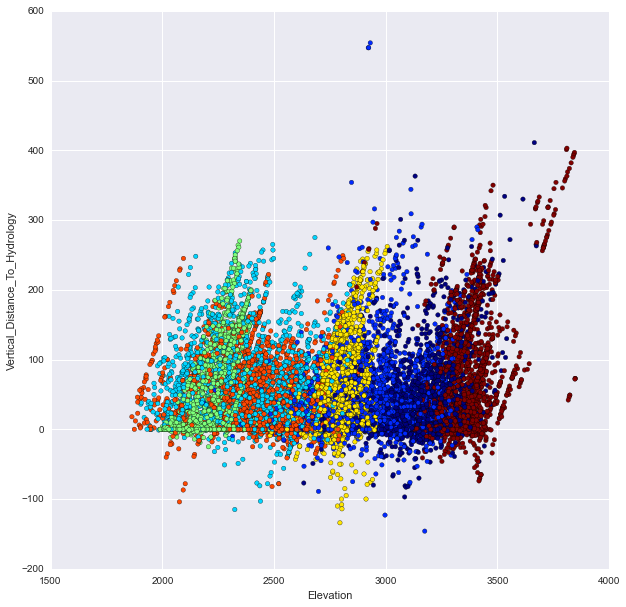

In [264]:
#Plotting vertical distance to hydrology VS elevation with color coded forest cover labels

plt.figure(figsize=(10,10))
plt.scatter(X_train[:,0],X_train[:,4],c=y_train,cmap=plt.cm.jet)
plt.xlabel(name_features[1])
plt.ylabel(name_features[5])
plt.show()

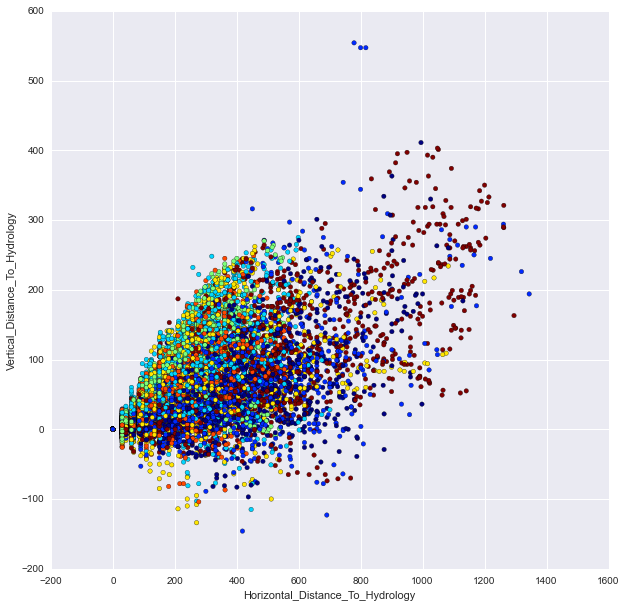

In [265]:
#Plotting vertical distance to hydrology VS horizontal distance to hydrology with color coded forest cover labels

plt.figure(figsize=(10,10))
plt.scatter(X_train[:,3],X_train[:,4],c=y_train,cmap=plt.cm.jet)
plt.xlabel(name_features[4])
plt.ylabel(name_features[5])
plt.show()

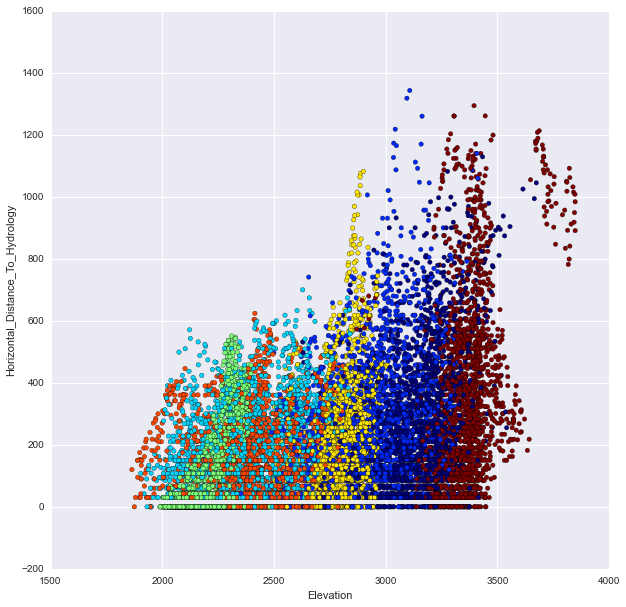

In [266]:
#Plotting horizontal distance to hydrology VS elevation with color coded forest cover labels

plt.figure(figsize=(10,10))
plt.scatter(X_train[:,0],X_train[:,3],c=y_train,cmap=plt.cm.jet)
plt.xlabel(name_features[1])
plt.ylabel(name_features[4])
plt.show()

###Engineering new features

1. Compute the euclidean distance based on horizontal and vertical distance to hydrology
2. Adding horizontal distance to Fire-Points and RoadWays
3. Subtracting horizontal distance to Fire-Points and RoadWays
4. Adding Elevation, Horizontal distance to hydrology and vertical distance to hydrology
5. Subtracting Elevation and 0.2*Horizontal Distance to Hydrology
6. Subtracting Elevation and Vertical Distance to Hydrology

In [267]:
name_features = column_names_test.split(",")

dist_EucH = metrics.euclidean_distances(X_train[:,(3,4)], np.array([0,0]))
dist_FR_add = np.add(X_train[:,5] ,X_train[:,9]).reshape(X_train.shape[0],1)
dist_FR_sub = np.subtract(X_train[:,5] ,X_train[:,9]).reshape(X_train.shape[0],1)
dist_EHV = (X_train[:,0] + X_train[:,3]+X_train[:,4]).reshape(X_train.shape[0],1)
E_minus_R = (X_train[:,0] - 0.2*X_train[:,5]).reshape(X_train.shape[0],1)
E_minus_V = (X_train[:,0] - X_train[:,4]).reshape(X_train.shape[0],1)

X_train_new = np.append(X_train,dist_EucH,axis=1)
X_train_new = np.append(X_train_new,dist_FR_add,axis=1)
X_train_new = np.append(X_train_new,dist_FR_sub,axis=1)
X_train_new = np.append(X_train_new,dist_EHV,axis=1)
X_train_new = np.append(X_train_new,E_minus_R,axis=1)
X_train_new = np.append(X_train_new,E_minus_V,axis=1)

dist_EucH = metrics.euclidean_distances(X_dev[:,(3,4)], np.array([0,0]))
dist_FR_add = np.add(X_dev[:,5] ,X_dev[:,9]).reshape(X_dev.shape[0],1)
dist_FR_sub = np.subtract(X_dev[:,5] ,X_dev[:,9]).reshape(X_dev.shape[0],1)
dist_EHV = (X_dev[:,0] + X_dev[:,3]+X_dev[:,4]).reshape(X_dev.shape[0],1)
E_minus_R = (X_dev[:,0] - 0.2*X_dev[:,5]).reshape(X_dev.shape[0],1)
E_minus_V = (X_dev[:,0] - X_dev[:,4]).reshape(X_dev.shape[0],1)

X_dev_new = np.append(X_dev,dist_EucH,axis=1)
X_dev_new = np.append(X_dev_new,dist_FR_add,axis=1)
X_dev_new = np.append(X_dev_new,dist_FR_sub,axis=1)
X_dev_new = np.append(X_dev_new,dist_EHV,axis=1)
X_dev_new = np.append(X_dev_new,E_minus_R,axis=1)
X_dev_new = np.append(X_dev_new,E_minus_V,axis=1)

name_features.append("dist_Euch")
name_features.append("dist_FR_add")
name_features.append("dist_FR_sub")
name_features.append("dist_EHV")
name_features.append("E_minus_R")
name_features.append("E_minus_V")

In [298]:
dist_EucH = metrics.euclidean_distances(X_test[:,(3,4)], np.array([0,0]))
dist_FR_add = np.add(X_test[:,5] ,X_test[:,9]).reshape(X_test.shape[0],1)
dist_FR_sub = np.subtract(X_test[:,5] ,X_test[:,9]).reshape(X_test.shape[0],1)
dist_EHV = (X_test[:,0] + X_test[:,3]+X_test[:,4]).reshape(X_test.shape[0],1)
E_minus_R = (X_test[:,0] - 0.2*X_test[:,5]).reshape(X_test.shape[0],1)
E_minus_V = (X_test[:,0] - X_test[:,4]).reshape(X_test.shape[0],1)

X_test_new = np.append(X_test,dist_EucH,axis=1)
X_test_new = np.append(X_test_new,dist_FR_add,axis=1)
X_test_new = np.append(X_test_new,dist_FR_sub,axis=1)
X_test_new = np.append(X_test_new,dist_EHV,axis=1)
X_test_new = np.append(X_test_new,E_minus_R,axis=1)
X_test_new = np.append(X_test_new,E_minus_V,axis=1)

Training Adaboost on the newly engineered features:

Accuracy (adaboost with decision trees NORMAL new feature): 0.906084656085


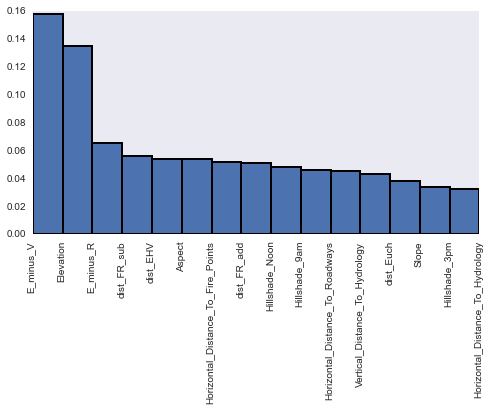

|    |    1|    2|    3|    4|    5|    6|    7|
------------------------------------------------
|   1| 80.0| 11.8|  0.0|  0.0|  1.4|  0.0|  6.8|
|   2| 12.5| 76.9|  4.3|  0.0|  4.3|  1.9|  0.0|
|   3|  0.0|  0.0| 87.3|  0.9|  0.5| 11.4|  0.0|
|   4|  0.0|  0.0|  0.5| 99.0|  0.0|  0.5|  0.0|
|   5|  0.0|  1.3|  1.3|  0.0| 96.9|  0.4|  0.0|
|   6|  0.0|  0.0|  5.3|  0.0|  0.0| 94.7|  0.0|
|   7|  0.9|  0.0|  0.0|  0.0|  0.0|  0.0| 99.1|



In [268]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=500)
abc.fit(X_train_new, y_train)
y_pred = abc.predict(X_dev_new)
print 'Accuracy (adaboost with decision trees NORMAL new feature):', abc.score(X_dev_new,y_dev)

plot_important_features(abc,15,name_features)

print_confusion_matrix(y_dev,y_pred)

In [185]:
AB = AdaBoostClassifier(base_estimator=DT, n_estimators=500)
AB.fit(X_train, y_train)
pred_y_dev_AB = AB.predict(X_dev)
acc_AB = metrics.accuracy_score(y_dev, pred_y_dev_AB)
print acc_AB

CM = metrics.confusion_matrix(y_dev, pred_y_dev_AB)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_AB_perType = np.diag(acc)
print acc_AB_perType

0.816798941799
[ 0.70454545  0.59615385  0.74545455  0.94811321  0.91189427  0.83009709
  0.97260274]


In [186]:
AB = AdaBoostClassifier(base_estimator=RF, n_estimators=500)
AB.fit(X_train, y_train)
pred_y_dev_AB = AB.predict(X_dev)
acc_AB = metrics.accuracy_score(y_dev, pred_y_dev_AB)
print acc_AB

CM = metrics.confusion_matrix(y_dev, pred_y_dev_AB)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_AB_perType = np.diag(acc)
print acc_AB_perType

0.890873015873
[ 0.8         0.74038462  0.83636364  0.98113208  0.94713656  0.94660194
  0.98173516]


In [188]:
AB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), 
                        n_estimators=500)
AB.fit(X_train, y_train)
pred_y_dev_AB = AB.predict(X_dev)
acc_AB = metrics.accuracy_score(y_dev, pred_y_dev_AB)
print acc_AB

CM = metrics.confusion_matrix(y_dev, pred_y_dev_AB)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_AB_perType = np.diag(acc)
print acc_AB_perType

0.896164021164
[ 0.77272727  0.74519231  0.86818182  0.98584906  0.96035242  0.95145631
  0.98630137]


In [189]:
AB = AdaBoostClassifier(base_estimator=ET, n_estimators=500)
AB.fit(X_train, y_train)
pred_y_dev_AB = AB.predict(X_dev)
acc_AB = metrics.accuracy_score(y_dev, pred_y_dev_AB)
print acc_AB

CM = metrics.confusion_matrix(y_dev, pred_y_dev_AB)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_AB_perType = np.diag(acc)
print acc_AB_perType

0.904761904762
[ 0.76818182  0.8125      0.87727273  0.98113208  0.96475771  0.94174757
  0.98630137]


Predict the test set:

In [190]:
pred_y_test_AB = AB.predict(X_test)

Let's try now with the new features:

In [295]:
ET = ensemble.ExtraTreesClassifier(criterion='entropy', n_estimators=150, 
                                   min_samples_split=2, random_state=0)
AB_eng = AdaBoostClassifier(base_estimator=ET, n_estimators=500)
AB_eng.fit(X_train_new, y_train)
pred_y_dev_AB_eng = AB_eng.predict(X_dev_new)
acc_AB_eng = metrics.accuracy_score(y_dev, pred_y_dev_AB_eng)
print acc_AB_eng

CM = metrics.confusion_matrix(y_dev, pred_y_dev_AB_eng)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_AB_eng_perType = np.diag(acc)
print acc_AB_eng_perType

0.912698412698
[ 0.83181818  0.80769231  0.87727273  0.97169811  0.97356828  0.94174757
  0.98173516]


Predict the test set:

In [300]:
pred_y_test_AB_eng = AB_eng.predict(X_test_new)

<a id='GB'></a>

##Gradient Boosting Classifier

<a href='#top'>[Back to top]</a>


In [169]:
GB = GradientBoostingClassifier(learning_rate=0.2, subsample=1, max_features=10, 
                               n_estimators=2000, max_leaf_nodes=5)
GB.fit(X_train, y_train)
preds_GB = GB.predict(X_dev)
print metrics.accuracy_score(y_dev, preds_GB)
print classification_report(y_dev, preds_GB)

0.871031746032
             precision    recall  f1-score   support

          1       0.80      0.76      0.78       220
          2       0.77      0.69      0.73       208
          3       0.86      0.84      0.85       220
          4       0.99      0.97      0.98       212
          5       0.91      0.93      0.92       227
          6       0.81      0.91      0.86       206
          7       0.94      0.99      0.97       219

avg / total       0.87      0.87      0.87      1512



Keep record of the predictions in the dev set, as well as the accuracy, to ensemble all the models in a later step:

In [191]:
GB = GradientBoostingClassifier(learning_rate=0.2, subsample=1, max_features=10, 
                               n_estimators=2000, max_leaf_nodes=5)
GB.fit(X_train, y_train)
pred_y_dev_GB = GB.predict(X_dev)
acc_GB = metrics.accuracy_score(y_dev, pred_y_dev_GB)
print acc_GB

CM = metrics.confusion_matrix(y_dev, pred_y_dev_GB)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_GB_perType = np.diag(acc)
print acc_GB_perType

0.871031746032
[ 0.74545455  0.6875      0.84090909  0.96226415  0.94273128  0.92718447
  0.98630137]


Predict the test set:

In [245]:
pred_y_test_GB = GB.predict(X_test)

<a id='SVM'></a>

##Support Vector Machines

<a href='#top'>[Back to top]</a>


In [193]:
param_grid = {'C': [1, 10, 100, 1000], 
              'gamma': [1, 0.5, 0.1, 0.01], 
              'kernel': ['rbf']}
    # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
best_svm = GridSearchCV(SVC(), param_grid, scoring='accuracy')
best_svm.fit(X_train_minmax, y_train)
best_svm.score(X_dev_minmax, y_dev)
print best_svm.best_params_

svm = SVC(kernel = best_svm.best_params_['kernel'], C=best_svm.best_params_['C'],
          gamma=best_svm.best_params_['gamma'])
svm.fit(X_train_minmax, y_train)
svm_preds = svm.predict(X_dev_minmax)
print metrics.accuracy_score(y_dev, svm_preds)
print classification_report(y_dev, svm_preds)

{'kernel': 'rbf', 'C': 1000, 'gamma': 0.5}
0.846560846561
             precision    recall  f1-score   support

          1       0.78      0.72      0.75       220
          2       0.75      0.72      0.73       208
          3       0.80      0.77      0.78       220
          4       0.94      0.97      0.95       212
          5       0.89      0.93      0.91       227
          6       0.81      0.85      0.83       206
          7       0.93      0.97      0.95       219

avg / total       0.84      0.85      0.84      1512



Keep record of the predictions in the dev set, as well as the accuracy, to ensemble all the models in a later step:

In [167]:
SVM = SVC(kernel='rbf', C=1000, gamma=0.5)
SVM.fit(X_train_minmax, y_train)
pred_y_dev_SVM = SVM.predict(X_dev_minmax)
acc_SVM = metrics.accuracy_score(y_dev, pred_y_dev_SVM)
print acc_SVM

CM = metrics.confusion_matrix(y_dev, pred_y_dev_SVM)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_SVM_perType = np.diag(acc)
print acc_SVM_perType

0.846560846561
[ 0.72272727  0.71634615  0.76818182  0.97169811  0.92511013  0.84951456
  0.96803653]


Predict the test set:

In [168]:
pred_y_test_SVM = SVM.predict(X_test_minmax)

<a id='Log_Regression'></a>

##Logistic Regression

<a href='#top'>[Back to top]</a>


In [163]:
#Using training data scaled to 0 -> 1 

logR = LogisticRegression(penalty='l2',C=10)
logR.fit(X_train_minmax, y_train)
y_pred = logR.predict(X_dev_minmax)

print "### Using training data scaled to 0 -> 1 ###\n"

#print metrics.f1_score(y_dev, y_pred, average='macro')
print classification_report(y_dev,y_pred)
# Confusion Matrix
CM = metrics.confusion_matrix(y_dev, y_pred)
CM_percentage = np.around(100*CM.astype('f2') / CM.sum(axis=1)[:, np.newaxis], 1)

#Regular data
logR = LogisticRegression(penalty='l2',C=10)
logR.fit(X_train, y_train)
y_pred = logR.predict(X_dev)

print "### Regular data ###\n"
#print metrics.f1_score(y_dev, y_pred, average='macro')
print classification_report(y_dev,y_pred)
# Confusion Matrix
CM = metrics.confusion_matrix(y_dev, y_pred)
CM_percentage = np.around(100*CM.astype('f2') / CM.sum(axis=1)[:, np.newaxis], 1)

#Using training data scaled to mean 0 and variance 1
logR = LogisticRegression(penalty='l2',C=10)
logR.fit(X_train_std[:,:10], y_train)
y_pred = logR.predict(X_dev_std[:,:10])

print "### Using training data scaled to mean 0 and variance 1 ###"
#print metrics.f1_score(y_dev, y_pred, average='macro')
print classification_report(y_dev,y_pred)
# Confusion Matrix
CM = metrics.confusion_matrix(y_dev, y_pred)
CM_percentage = np.around(100*CM.astype('f2') / CM.sum(axis=1)[:, np.newaxis], 1)

### Using training data scaled to 0 -> 1 ###

             precision    recall  f1-score   support

          1       0.67      0.67      0.67       220
          2       0.63      0.56      0.59       208
          3       0.53      0.55      0.54       220
          4       0.83      0.84      0.84       212
          5       0.66      0.73      0.69       227
          6       0.55      0.52      0.54       206
          7       0.87      0.85      0.86       219

avg / total       0.68      0.68      0.68      1512

### Regular data ###

             precision    recall  f1-score   support

          1       0.67      0.64      0.65       220
          2       0.61      0.53      0.57       208
          3       0.52      0.46      0.49       220
          4       0.81      0.85      0.83       212
          5       0.66      0.71      0.69       227
          6       0.53      0.60      0.56       206
          7       0.84      0.87      0.86       219

avg / total       0.66    

Keep record of the predictions in the dev set, as well as the accuracy, to ensemble all the models in a later step:

In [164]:
LR = LogisticRegression(penalty='l2',C=10)
LR.fit(X_train_minmax, y_train)
pred_y_dev_LR = LR.predict(X_dev_minmax)
acc_LR = metrics.accuracy_score(y_dev, pred_y_dev_LR)
print acc_LR

CM = metrics.confusion_matrix(y_dev, pred_y_dev_LR)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_LR_perType = np.diag(acc)
print acc_LR_perType

0.677248677249
[ 0.67272727  0.55769231  0.55        0.84433962  0.73127753  0.52427184
  0.84931507]


Predict the test set:

In [165]:
pred_y_test_LR = LR.predict(X_test_minmax)

<a id='SGD'></a>

##Stochastic Gradient Descent (SGD)

<a href='#top'>[Back to top]</a>


In [160]:
sgd_clf = linear_model.SGDClassifier(alpha=0.001, n_iter=1000)
sgd_clf.fit(X_train_minmax, y_train)
y_dev_sgd= sgd_clf.predict(X_dev_minmax)
print metrics.classification_report(y_dev, y_dev_sgd)
print metrics.accuracy_score(y_dev, y_dev_sgd)

             precision    recall  f1-score   support

          1       0.54      0.78      0.64       220
          2       0.71      0.25      0.36       208
          3       0.57      0.33      0.41       220
          4       0.74      0.84      0.79       212
          5       0.63      0.73      0.68       227
          6       0.49      0.69      0.57       206
          7       0.87      0.81      0.84       219

avg / total       0.65      0.63      0.61      1512

0.632936507937


Keep record of the predictions in the dev set, as well as the accuracy, to ensemble all the models in a later step:

In [161]:
SGD = linear_model.SGDClassifier(alpha=0.001, n_iter=1000)
SGD.fit(X_train_minmax, y_train)
pred_y_dev_SGD = SGD.predict(X_dev_minmax)
acc_SGD = metrics.accuracy_score(y_dev, pred_y_dev_SGD)
print acc_SGD

CM = metrics.confusion_matrix(y_dev, pred_y_dev_SGD)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_SGD_perType = np.diag(acc)
print acc_SGD_perType

0.628968253968
[ 0.78181818  0.22115385  0.32727273  0.83962264  0.71365639  0.69902913
  0.80821918]


Predict the test set:

In [162]:
pred_y_test_SGD = SGD.predict(X_test_minmax)

<a id='GMM'></a>

##Gaussian Mixture Model

<a href='#top'>[Back to top]</a>


In [135]:
best_covar_type = ''
best_numcomp = 0
dev_accuracy = 0
for cov in ['spherical', 'diag', 'tied', 'full']:
    for comp in range(40,400,40):
        logprob = np.empty(len(np.unique(y_train))*X_dev.shape[0]).\
            reshape(len(np.unique(y_train)), X_dev.shape[0])
        for i,label in enumerate(np.unique(y_train)):
            gmm = GMM(n_components=comp, covariance_type=cov)
            gmm.fit(X_train[y_train==label])
            logprob[i, :] = gmm.score(X_dev)
        preds = logprob.argmax(axis=0) + 1
        acc = metrics.accuracy_score(y_dev, preds)
        if acc > dev_accuracy:
            dev_accuracy = acc
            best_numcomp = comp
            best_covar_type =  cov
print dev_accuracy, best_numcomp, best_covar_type

0.847883597884 320 tied


In [136]:
logprob = np.empty(len(np.unique(y_train))*X_dev.shape[0]).\
            reshape(len(np.unique(y_train)), X_dev.shape[0])
for i,label in enumerate(np.unique(y_train)):
    gmm = GMM(n_components=best_numcomp, covariance_type=best_covar_type)
    gmm.fit(X_train[y_train==label])
    logprob[i, :] = gmm.score(X_dev)
preds = logprob.argmax(axis=0) + 1
print metrics.classification_report(y_dev, preds)

             precision    recall  f1-score   support

          1       0.74      0.81      0.78       220
          2       0.75      0.69      0.72       208
          3       0.81      0.83      0.82       220
          4       0.97      0.92      0.94       212
          5       0.96      0.93      0.94       227
          6       0.82      0.88      0.85       206
          7       0.96      0.95      0.95       219

avg / total       0.86      0.86      0.86      1512



Keep record of the predictions in the dev set, as well as the accuracy, to ensemble all the models in a later step:

In [137]:
logprob = np.empty(len(np.unique(y_train))*X_dev.shape[0]).\
            reshape(len(np.unique(y_train)), X_dev.shape[0])
for i,label in enumerate(np.unique(y_train)):
    gmm = GMM(n_components=320, covariance_type='tied')
    gmm.fit(X_train[y_train==label])
    logprob[i, :] = gmm.score(X_dev)
pred_y_dev_GMM = logprob.argmax(axis=0) + 1
acc_GMM = metrics.accuracy_score(y_dev, pred_y_dev_GMM)
print acc_GMM

CM = metrics.confusion_matrix(y_dev, pred_y_dev_GMM)
acc = CM.astype('f8') / CM.sum(axis=1)[:, np.newaxis]
acc_GMM_perType = np.diag(acc)
print acc_GMM_perType

0.838624338624
[ 0.77727273  0.63461538  0.84545455  0.88679245  0.92070485  0.86893204
  0.92694064]


Predict the test set:

In [156]:
logprob = np.empty(len(np.unique(y_train))*X_test.shape[0]).\
        reshape(len(np.unique(y_train)), X_test.shape[0])
for i,label in enumerate(np.unique(y_train)):
    gmm = GMM(n_components=320, covariance_type='tied')
    gmm.fit(X_train[y_train==label])
    logprob[i, :] = gmm.score(X_test)
pred_y_test_GMM = logprob.argmax(axis=0) + 1

<a id='Ensemble'></a>

##Ensemble

<a href='#top'>[Back to top]</a>

Of the 11 models that we've built, we are going to ensemble only the 7 models with an accuracy higher than 80%, discarding LR, SGD, and NB, with an accuracy less than 70%.


In [232]:
acc = np.hstack((acc_kNN, acc_DT, acc_RF, acc_ET, acc_AB, acc_GB, acc_SVM, acc_GMM))
print acc

[ 0.85383598  0.81812169  0.88756614  0.89351852  0.9047619   0.87103175
  0.84656085  0.83862434]


These 8 models are less accurate at detecting Types 1 and 2 (and Type 7 is almost always the one classified with more accuracy).

In [233]:
acc_perType = np.vstack((acc_kNN_perType, acc_DT_perType, acc_RF_perType, 
                         acc_ET_perType, acc_AB_perType, acc_GB_perType, 
                         acc_SVM_perType, acc_GMM_perType))
print acc_perType

[[ 0.67272727  0.66346154  0.80909091  0.96226415  0.96475771  0.90776699
   0.99086758]
 [ 0.67727273  0.62019231  0.75909091  0.94339623  0.9030837   0.85436893
   0.96347032]
 [ 0.80454545  0.72596154  0.83181818  0.98113208  0.95594714  0.9368932
   0.97260274]
 [ 0.77727273  0.75961538  0.85        0.98113208  0.96035242  0.9368932
   0.98630137]
 [ 0.76818182  0.8125      0.87727273  0.98113208  0.96475771  0.94174757
   0.98630137]
 [ 0.74545455  0.6875      0.84090909  0.96226415  0.94273128  0.92718447
   0.98630137]
 [ 0.72272727  0.71634615  0.76818182  0.97169811  0.92511013  0.84951456
   0.96803653]
 [ 0.77727273  0.63461538  0.84545455  0.88679245  0.92070485  0.86893204
   0.92694064]]


To ensemble the 7 models with accuracy greater than 80%, we apply the following reasoning:

Let's suppose there are only 2 categories, and the 7 models have a 80% accuracy at predicting one or the other. Let's also assume that the results of each model are uncorrelated to the others'.
Then:

$\Pr (7 \text{ successes}) = {7 \choose 7} \cdot 0.8^7 \cdot 0.2^0 = 1 \cdot 0.20972 \cdot 1 = 0.20972$ 

$\Pr (6 \text{ successes}) = {7 \choose 6} \cdot 0.8^6 \cdot 0.2^1 = 7 \cdot 0.26214 \cdot 0.2 = 0.36700$

$\Pr (5 \text{ successes}) = {7 \choose 5} \cdot 0.8^5 \cdot 0.2^2 = 21 \cdot 0.32768 \cdot 0.04 = 0.27525$

$\Pr (4 \text{ successes}) = {7 \choose 4} \cdot 0.8^4 \cdot 0.2^3 = 35 \cdot 0.4096 \cdot 0.008 = 0.11469$

$\Pr (3 \text{ successes}) = {7 \choose 3} \cdot 0.8^3 \cdot 0.2^4 = 35 \cdot 0.512 \cdot 0.0016 = 0.02867$

$\Pr (2 \text{ successes}) = {7 \choose 2} \cdot 0.8^2 \cdot 0.2^5 = 21 \cdot 0.64 \cdot 0.00032 = 0.00430$

$\Pr (1 \text{ success}) = {7 \choose 1} \cdot 0.8^1 \cdot 0.2^6 = 7 \cdot 0.8 \cdot 0.00006 = 0.00036$ 

$\Pr (0 \text{ successes}) = {7 \choose 0} \cdot 0.8^0 \cdot 0.2^7 = 1 \cdot 1 \cdot 0.00001 = 0.00001$ 

And hence by combining the predictions of these 7 models we'd be able to increase our accuracy quite much:

$\Pr (\text{4 or more successes}) = \sum_{i=4}^7 \Pr(i \text{ successes}) = 0.96666$ 

In the event that 6 of the 7 models make exactly the same prediction than the first, then:

$\Pr (7 \text{ successes}) = \Pr (\text{1st model is successful}) = 0.8$

$\Pr (6 \text{ successes}) = \text{ . . . } = \Pr (1 \text{ success}) = 0$

$\Pr (0 \text{ successes}) = \Pr (\text{1st model is unsuccessful}) = 0.2$ 

So in this worst-case scenario our success rate still would be 80%.

To ensemble all results we can follow 3 different approaches

1. **Select the most frequent category**. If the 7 models predict 1, 2, 4, 4, 4, 5, 5 for one test example, we would select 4 (and in case of a tie, say 1, 2, 3, 4, 4, 5, 5, the lowest number, 4, is chosen).

2. **Select the most frequent category, weighting each model by its overall accuracy**. If the 7 models predict 1, 2, 3, 4, 4, 5, 5 for one test example, the prediction would be based on the overall accuracies of the models that predicted 4 or 5. If those accuracies are 83% and 83%, and 80% and 84%, respectively, 4 would be chosen.

3. **Select the most frequent category, weighting each model by its accuracy for the category they've predicted**. Following the previous example, suppose the 2 models that predicted 4 have an 83% overall accuracy, but their accuracy for 4 is only 40% (and 90% for the other categories); if the models that predicted 5 are more accurate predicting that category than 40%, 5 would be chosen.

In [234]:
# Predictions of the best 7 modesl for the first 10 examples in the dev set
preds = np.column_stack((pred_y_dev_kNN, pred_y_dev_DT, pred_y_dev_RF, 
                         pred_y_dev_ET, pred_y_dev_AB, pred_y_dev_GB, 
                         pred_y_dev_SVM, pred_y_dev_GMM))
print preds[:10,:], '\n'


counts = np.apply_along_axis(np.bincount, 1, preds, minlength=8)
pred_y_dev_ensemble = np.argmax(counts, axis=1)
print pred_y_dev_ensemble[:10], '\n'
acc_ensemble = metrics.accuracy_score(y_dev, pred_y_dev_ensemble)
print acc_ensemble

[[7 7 1 1 1 1 1 7]
 [5 5 5 5 5 5 5 5]
 [6 3 3 3 3 6 6 6]
 [4 4 4 4 4 4 4 4]
 [1 2 2 2 2 1 2 1]
 [4 4 4 4 4 4 6 6]
 [1 1 1 1 1 1 1 2]
 [3 6 6 6 6 6 6 6]
 [4 4 4 4 4 4 4 3]
 [3 3 3 3 3 3 3 3]] 

[1 5 3 4 2 4 1 6 4 3] 

0.903439153439


If we give equal weight to each model, the accuracy is lower than that of the best model (AdaBoost).

In [230]:
# Predictions of the best 7 models for the first 10 examples in the dev set
print preds[:10,:], '\n'

counts = np.apply_along_axis(np.bincount, 1, preds, minlength=8, weights=acc)
pred_y_dev_ensemble = np.argmax(counts, axis=1)
print pred_y_dev_ensemble[:10], '\n'
acc_ensemble = metrics.accuracy_score(y_dev, pred_y_dev_ensemble)
print acc_ensemble

[[7 7 1 1 1 1 1 7]
 [5 5 5 5 5 5 5 5]
 [6 3 3 3 3 6 6 6]
 [4 4 4 4 4 4 4 4]
 [1 2 2 2 2 1 2 1]
 [4 4 4 4 4 4 6 6]
 [1 1 1 1 1 1 1 2]
 [3 6 6 6 6 6 6 6]
 [4 4 4 4 4 4 4 3]
 [3 3 3 3 3 3 3 3]] 

[1 5 3 4 2 4 1 6 4 3] 

0.900793650794


If we weight each model by its overall accuracy, the accuracy is 0.12 percentage points greater than the best model (AdaBoost).

In [235]:
# Predictions of the best 7 modesl for the first 10 examples in the dev set
print preds[:10,:], '\n'

pred_y_dev_ensemble = np.empty(preds.shape[0], dtype='u4')
for i in range(preds.shape[0]):
    w = np.zeros(8)
    for j in range(8):
        w[j] = acc_perType[j,preds[i,j]-1]
    counts = np.bincount(preds[i,:], minlength=8, weights=w)
    pred_y_dev_ensemble[i] = np.argmax(counts)
print pred_y_dev_ensemble[:10], '\n'
acc_ensemble = metrics.accuracy_score(y_dev, pred_y_dev_ensemble)
print acc_ensemble

[[7 7 1 1 1 1 1 7]
 [5 5 5 5 5 5 5 5]
 [6 3 3 3 3 6 6 6]
 [4 4 4 4 4 4 4 4]
 [1 2 2 2 2 1 2 1]
 [4 4 4 4 4 4 6 6]
 [1 1 1 1 1 1 1 2]
 [3 6 6 6 6 6 6 6]
 [4 4 4 4 4 4 4 3]
 [3 3 3 3 3 3 3 3]] 

[1 5 6 4 2 4 1 6 4 3] 

0.900132275132


If we weight each model by its accuracy for the category it has predicted, the accuracy is lower than that of the best model (AdaBoost).

**The small improvement in the 3 cases is because the predictions of all models are highly correlated (they tend to fail in the same cases).**

In [250]:
# Predictions of the best 7 models for the first 10 examples in the test set
preds_test = np.column_stack((pred_y_test_kNN, pred_y_test_DT, pred_y_test_RF, 
                              pred_y_test_ET, pred_y_test_AB, pred_y_test_GB, 
                              pred_y_test_SVM, pred_y_test_GMM))
print preds_test[:10,:], '\n'

counts = np.apply_along_axis(np.bincount, 1, preds_test, minlength=8, weights=acc)
pred_y_test_ensemble = np.argmax(counts, axis=1)
print pred_y_test_ensemble[:10], '\n'

[[2 2 2 2 2 5 2 1]
 [2 2 2 2 2 5 2 1]
 [1 5 2 2 2 5 2 2]
 [1 5 2 2 2 5 2 2]
 [1 5 2 2 2 5 2 2]
 [1 5 2 2 2 5 2 2]
 [2 5 2 2 2 5 2 2]
 [2 5 2 2 2 5 2 1]
 [2 5 2 2 2 5 2 2]
 [2 5 2 2 2 5 2 1]] 

[2 2 2 2 2 2 2 2 2 2] 



It seems like there are a lot of `2`'s. Mere chance?

In [274]:
for i in range(1,8):
    print 'Number of {0}\'s: {1}'.format(i, pred_y_test_ensemble[pred_y_test_ensemble==i].shape[0])

Number of 1's: 209941
Number of 2's: 235527
Number of 3's: 35906
Number of 4's: 2022
Number of 5's: 28632
Number of 6's: 24640
Number of 7's: 29224


Yes, and also a lot of `1`'s. Both account for almost 80% of cases in our predictions:

In [280]:
print 100.0* (pred_y_test_ensemble[pred_y_test_ensemble==1].shape[0] + 
              pred_y_test_ensemble[pred_y_test_ensemble==2].shape[0]) / pred_y_test_ensemble.shape[0]

78.7196143434


In [301]:
# Predictions of the best 7 models for the first 10 examples in the test set
preds_test = np.column_stack((pred_y_test_kNN, pred_y_test_DT, pred_y_test_RF, 
                              pred_y_test_ET, pred_y_test_AB_eng, pred_y_test_GB, 
                              pred_y_test_SVM, pred_y_test_GMM))
print preds_test[:10,:], '\n'

acc = np.hstack((acc_kNN, acc_DT, acc_RF, acc_ET, acc_AB_eng, acc_GB, acc_SVM, acc_GMM))
counts = np.apply_along_axis(np.bincount, 1, preds_test, minlength=8, weights=acc)
pred_y_test_ensemble = np.argmax(counts, axis=1)
print pred_y_test_ensemble[:10], '\n'

[[2 2 2 2 2 5 2 1]
 [2 2 2 2 2 5 2 1]
 [1 5 2 2 2 5 2 2]
 [1 5 2 2 2 5 2 2]
 [1 5 2 2 2 5 2 2]
 [1 5 2 2 2 5 2 2]
 [2 5 2 2 2 5 2 2]
 [2 5 2 2 2 5 2 1]
 [2 5 2 2 2 5 2 2]
 [2 5 2 2 2 5 2 1]] 

[2 2 2 2 2 2 2 2 2 2] 



<a id='Results'></a>

##Results

<a href='#top'>[Back to top]</a>


.........

In [303]:
predictions = pred_y_test_ensemble

Finally we'd  need to save the output to a textfile, and upload the results to kaggle (see https://www.kaggle.com/c/digit-recognizer/data for further information).

In [304]:
test_lab_f = open("test_labeled.csv", "w")
test_lab_f.write("Id,Cover_Type")

idx = X.shape[0]
                 
for pp in predictions:
    idx += 1
    test_lab_f.write("\n")
    test_lab_f.write(str(idx) + "," + str(int(pp)))
   
test_lab_f.close()

**And this is our result after submitting to Kaggle!**

<img src="image/kaggle_result_final.png">

<a id='Annex_1'></a>

##Annex 1: Plotting the training dataset

<a href='#top'>[Back to top]</a>


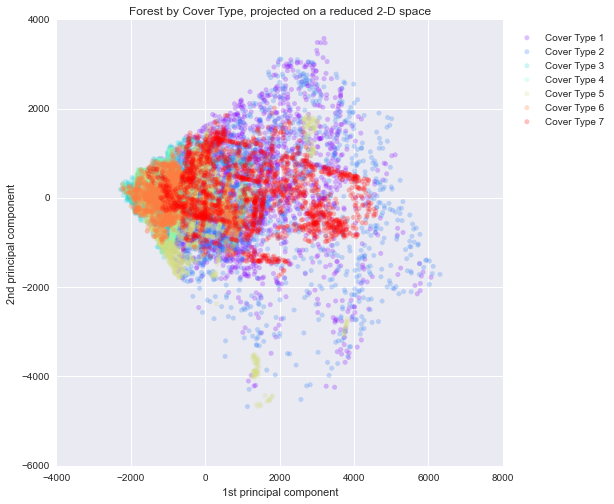

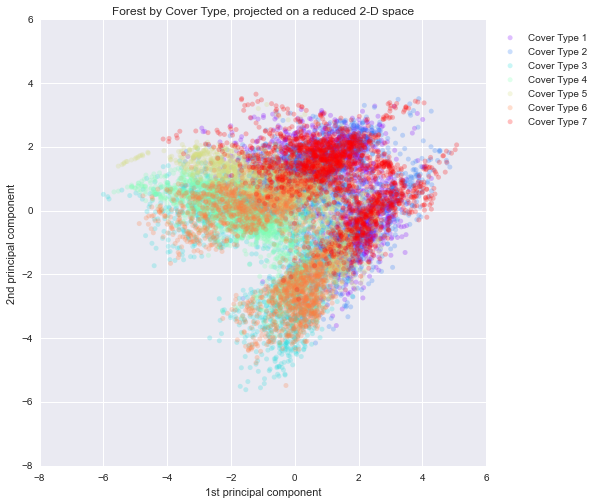

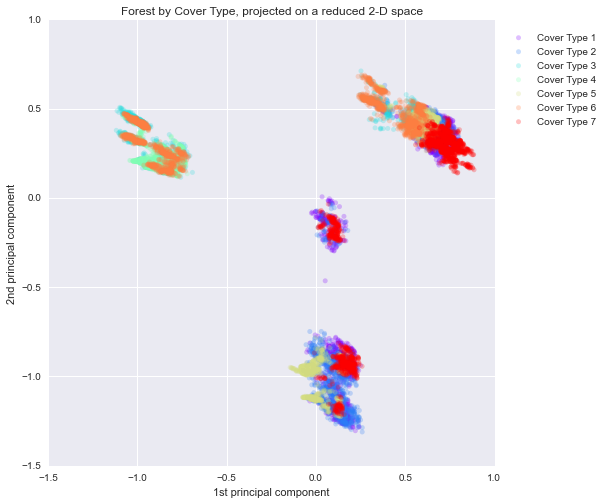

In [139]:
def plot(dataset):
    pc_2 = PCA(n_components=2)
    # Transform the coordinates into this new 2-D space
    X_train_2pc = pc_2.fit_transform(dataset)
    # Plot all elements of the training set in this 2-D space
    # Plot the projection of each forest in a 2-D space, with a color corresponding to each cover
        # type
    Colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(y_train))))
    # Each color is represented by 4 RGBA coordinates
    # cover_color = np.empty(4*X_train_2pc.shape[0]).reshape(X_train_2pc .shape[0], 4)
    # for i in np.arange(y_train.shape[0]):
        # color_index = y_train[i]-1
        # Each color is indexed by the cover type
        # cover_color[i,:] = Colors[color_index]
    plt.figure  (figsize = (8, 8))
    cover = np.empty(len(np.unique(y_train))).tolist()
    for i in range(len(np.unique(y_train))):
        cover[i] = plt.scatter(X_train_2pc[y_train==i+1,0], X_train_2pc[y_train==i+1,1], 
                               c = Colors[i], alpha = 0.25, s=25, edgecolor='',
                               label = 'Cover Type ' + str(i+1))
    plt.xlabel("1st principal component")
    plt.ylabel("2nd principal component")
    plt.title('Forest by Cover Type, projected on a reduced 2-D space')
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=1.)

plot(X_train)
plot(X_train_std)
plot(X_train_minmax)

<a id='Annex_2'></a>

##Annex 2: Feature analysis

<a href='#top'>[Back to top]</a>

Goal of this analysis is to  identify features that we may be able to engineer for better performance and results.

 * From the results of Random Forest Analysis Following comes up as 15 more features that are important
 * Use pairwise feature comparison to try identify correlated features.


15 most important features are

[ 0  5 13  9  3  4  6  1  7 10  8  2 23 12 51]
['Elevation', 'Horizontal_Distance_To_Roadways', 'Wilderness_Area4', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Hillshade_9am', 'Aspect', 'Hillshade_Noon', 'Wilderness_Area1', 'Hillshade_3pm', 'Slope', 'Soil_Type10', 'Wilderness_Area3', 'Soil_Type38']


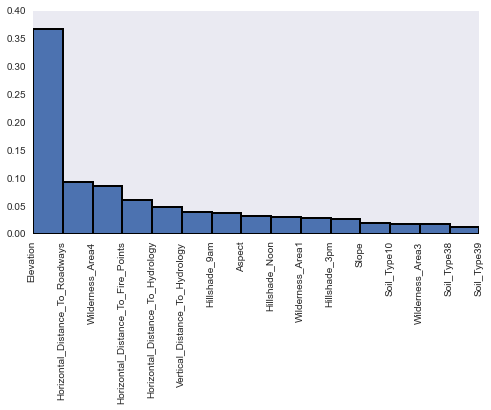

In [146]:
fet_ind=[]
def plot_important_features(rf,nFeatures) :
    global fet_ind
    plt.figure(figsize=(8, 4))
    fet_ind = np.argsort(rf.feature_importances_)[::-1]
    fet_imp = rf.feature_importances_[fet_ind][:nFeatures]
    feature_names = column_names_test.split(",")
    feature_names =feature_names[1:]
    feature_names_array=np.array(feature_names)[fet_ind]
    feature_names=feature_names_array[:nFeatures].tolist()
    
    print "%d most important features are\n" % nFeatures
    print fet_ind[:nFeatures]
    print feature_names
    
    #plot the bar chart for most important features 
    plt.bar(np.arange(len(fet_imp)), fet_imp, width=1, lw=2)
    plt.grid(False)
    xt = np.arange(len(fet_imp)+0.5)
    ax = plt.subplot(111)
    ax.set_xticks(xt)
    xlabels=feature_names_array.tolist()
    ax.set_xticklabels(xlabels, rotation=90)
    plt.xlim(0, len(fet_imp))

plot_important_features(RF,15)